In [65]:
import matplotlib.pyplot as plt
import numpy as np
import io,os
import datetime as dt
from h5py import File
import pandas as pd
import netCDF4 as nc
import scipy
import glob
import pdb
from cartopy import crs as ccrs

## Read in the NYC Emissions

In [22]:
emis = {}

with File('/home/sean/sata/ch4_emissions/nyc_ch4_emissions.h5','r') as f:
    for nm in ['pitt','epa','edgar']:
        emis[nm] = {}
        emis[nm]['fch4'] = f[nm][:]
        emis[nm]['categories'] = f.attrs[f'{nm}_categories'].split(';')

## Read in HALO Data and WRF boundary files to create enhancements
### `rec` is a dictionary for each flight with the receptor footprint, GHG boundary condition, and pressure
### `col` is a dictionary for each flight with the column footprint and GHG boundary condition

In [61]:
flts = ['20230726_F1','20230726_F2']
rec = {}
col = {}
for flt in flts:
    fp_prefix = f'halo_footprints/{flt}/'
    
    rec[flt] = {}
    col[flt] = {}
    
    bnd_files = sorted(glob.glob(f'wrf/{flt}/*wrfd01.h5'))
    rec[flt]['lon'],rec[flt]['lat'],rec[flt]['alt'] = \
        np.array([np.float32(bf.split('/')[-1].split('_')[1:4]) for bf in bnd_files]).T
    rec[flt]['bnd_co2'],rec[flt]['bnd_ch4'] = \
        np.zeros((len(bnd_files),500)),np.zeros((len(bnd_files),500))
    rec[flt]['p'] = np.zeros(len(bnd_files))
    rec[flt]['ps'] = np.zeros(len(bnd_files))
    rec[flt]['time'] = np.array([(dt.datetime.strptime(bf.split('/')[-1].split('_')[0],'%Y%m%d%H%M')- \
                                  dt.datetime(1970,1,1)).total_seconds() for bf in bnd_files])
    for enm in emis.keys():
        rec[flt][f'dch4_{enm}'] = np.zeros((len(bnd_files),emis[enm]['fch4'].shape[0])) # saving out the enhancements
    
    for ifl,fi in enumerate(bnd_files): # fi ~ 202307261606_-74.8424_40.6449_750_traj_bnd_wrfd01.h5
        rec[flt]['bnd_co2'][ifl],rec[flt]['bnd_ch4'][ifl] = File(fi)['wrf_co2'][:],File(fi)['wrf_ch4'][:]
        stub = fi.split('/')[-1].split('_')[:4]
        fp_fname = '_'.join(stub) # 202307261606_-74.8424_40.6449_750_foot.nc
        fp_fname += '_foot.nc'
        if os.path.exists(fp_prefix+fp_fname):
            ft = File(fp_prefix+fp_fname,'r')['foot'][:].sum(0)
            for enm in emis.keys():
                rec[flt][f'dch4_{enm}'][ifl] = (emis[enm]['fch4']*ft[None]).sum((1,2))
                
    wrf_file = File(f'wrf/{flt}_wrf_met.h5','r')
    wrf_lon,wrf_lat,wrf_alt,wrf_p,wrf_ps,wrf_t = \
        wrf_file['lon'][:],wrf_file['lat'][:],wrf_file['levs'][:], \
        wrf_file['pressure'][:],wrf_file['PSFC'][:],wrf_file['sample_time'][:]
    
    for ip in range(len(bnd_files)):
        ind = np.where((wrf_t == rec[flt]['time'][ip])*(wrf_lat == rec[flt]['lat'][ip])*(wrf_lon == rec[flt]['lon'][ip]))
        z_ind = np.where((rec[flt]['alt'][ip] == wrf_alt))
        
        rec[flt]['p'][ip] = wrf_p[ind,z_ind]
        rec[flt]['ps'][ip] = wrf_ps[ind,0]
        rec[flt]['time'][ip] = wrf_t[ind][0]
        
    col[flt]['xco2'] = []
    col[flt]['xch4'] = []
    col[flt]['xlat'] = []
    col[flt]['xlon'] = []
    col[flt]['xtime'] = []
    for enm in emis.keys():
        col[flt][f'dxch4_{enm}'] = []
        
    lat_set = list(set(rec[flt]['lat'][:]))
    for lat in lat_set:
        lat_inds = np.where(rec[flt]['lat'][:] == lat)
        lon_set = list(set(rec[flt]['lon'][lat_inds]))
        for lon in lon_set:
            lon_inds = np.where(rec[flt]['lon'][lat_inds] == lon)
            p = rec[flt]['p'][lat_inds][lon_inds]
            ps = rec[flt]['ps'][lat_inds][lon_inds][0]
            p_inds = np.argsort(p)
            p_ext = [ps]
            p_ext.extend(p[p_inds[::-1]])
            p_sort = np.array(p_ext)
            
            dp = []
            dp.extend(-np.diff(p_sort))
            dp = np.array(dp)
            levs = sorted(list(set(rec[flt]['alt'])))
            xch4 = 0.
            dxch4 = {}
            for enm in emis.keys():
                dxch4[enm] = np.zeros(emis[enm]['fch4'].shape[0])

            for ilev in range(len(dp)):
                lev_inds = np.where(rec[flt]['alt'][lat_inds][lon_inds] == levs[ilev])
                if rec[flt]['bnd_ch4'][lat_inds][lon_inds][lev_inds].shape[0] == 0: continue
                xch4 += np.median(rec[flt]['bnd_ch4'][lat_inds][lon_inds][lev_inds]) * dp[ilev]/dp.sum()
                xco2 += np.median(rec[flt]['bnd_co2'][lat_inds][lon_inds][lev_inds]) * dp[ilev]/dp.sum()
                for enm in emis.keys():
                    dxch4[enm] += rec[flt][f'dch4_{enm}'][lat_inds][lon_inds][lev_inds][0] * dp[ilev]/dp.sum()
                #pdb.set_trace()
            col[flt]['xco2'].append(xco2)
            col[flt]['xch4'].append(xch4)
            col[flt]['xlat'].append(lat)
            col[flt]['xlon'].append(lon)
            col[flt]['xtime'].append(rec[flt]['time'][lat_inds][lon_inds][lev_inds])
            for enm in emis.keys():
                col[flt][f'dxch4_{enm}'].append(dxch4[enm])
    for x in ['co2','ch4','lat','lon','time']:
        col[flt][f'x{x}'] = np.array(col[flt][f'x{x}']).flatten()
    for enm in emis.keys():
        col[flt][f'dxch4_{enm}'] = np.array(col[flt][f'dxch4_{enm}'])
print('Completed Successfully')

Completed Successfully


### `halo` is a dictionary with the HALO data and enhancements from the model background

In [3]:
halo = {}
for flt in flts:
    f = File(f'flight_data/{flt}_subCH4_3km_avg.h5','r')
    halo[flt] = {}
    halo[flt]['lat'] = f['lat'][:]
    halo[flt]['lon'] = f['lon'][:]
    halo[flt]['xch4'] = f['xch4'][:]
    halo[flt]['time'] = f['time'][:]
    halo[flt]['dxch4'] = halo[flt]['xch4']-rec[flt]['xch4']

In [92]:
col[flt][f'dxch4_{enm}'].shape
halo[flt][f'dxch4'].shape

(678,)

## XCH4 Enhancement Plots

- HALO-WRF_bck dXCH4
- Pitt dXCH4
- EDGAR dXCH4
- EPA dXCH4

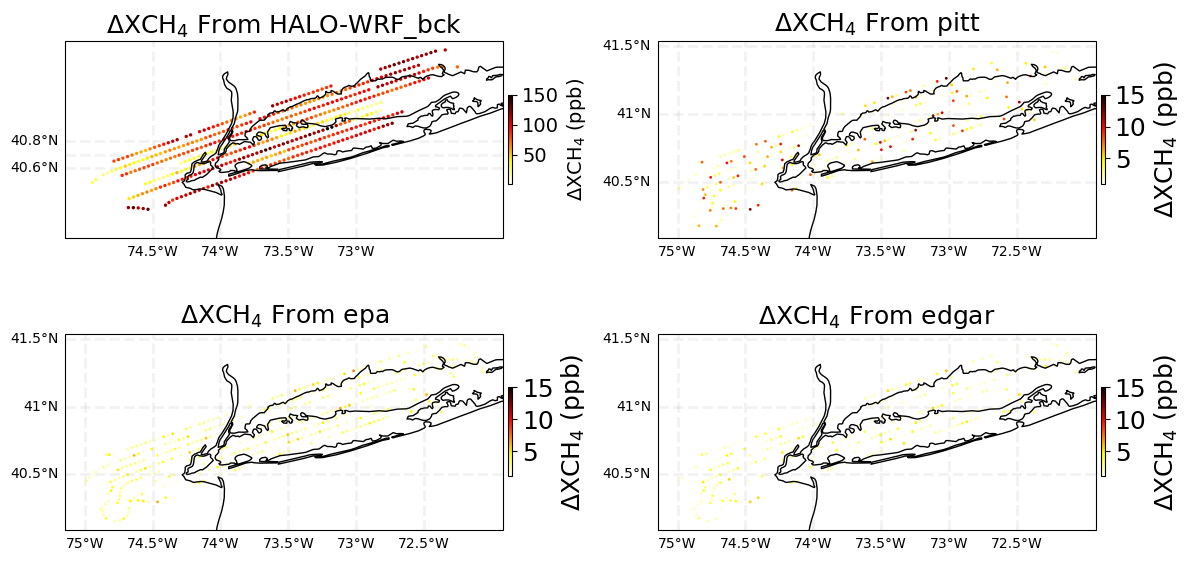

In [95]:
flt = '20230726_F1'
fig,axs = plt.subplots(2,2,figsize=(12,6),subplot_kw={'projection': ccrs.PlateCarree()})
bnds = [1,15]

ax = axs[0,0]
g = ax.scatter(halo[flt]['lon'],halo[flt]['lat'],c=halo[flt]['dxch4']*1e3,cmap=plt.cm.hot_r,transform=ccrs.PlateCarree(),vmin=bnds[0],vmax=150,s=2);
ax.coastlines()
cb = plt.colorbar(g,ax=ax,fraction=0.01,pad=0.01)#,orientation='horizontal')
ax.set_title(f'$\Delta$XCH$_4$ From HALO-WRF_bck',fontsize=18)
#ax.set_xticks(np.linspace(-75,-72,4))
cb.ax.tick_params(labelsize=14)
cb.ax.set_ylabel('$\Delta$XCH$_4$ (ppb)',fontsize=14)
#ax.contour(lon_2km,lat_2km,xco2_b_2km,np.array([-1.0]),cmap=plt.cm.terrain,linewidths=3)
gl = ax.gridlines(xlocs=[-74.5,-74.0,-73.5,-73.0],ylocs=[40.6,40.7,40.8],crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.1, linestyle='--')
gl.top_labels = False
gl.right_labels = False

for ik,ky in enumerate(emis.keys()):
    cmp = plt.cm.hot_r
    ax = axs[(ik+1)//2,(ik+1)%2]
    g = ax.scatter(halo[flt]['lon'],halo[flt]['lat'],c=col[flt][f'dxch4_{ky}'].sum(1)*1e3,cmap=cmp,transform=ccrs.PlateCarree(),vmin=bnds[0],vmax=bnds[1],s=1);
    ax.coastlines()
    cb = plt.colorbar(g,ax=ax,fraction=0.01,pad=0.01)#,orientation='horizontal')
    ax.set_title(f'$\Delta$XCH$_4$ From {ky}',fontsize=18)
    #ax.set_xticks(np.linspace(-75,72,4))
    cb.ax.tick_params(labelsize=18)
    cb.ax.set_ylabel('$\Delta$XCH$_4$ (ppb)',fontsize=18)
    #ax.contour(lon_2km,lat_2km,xco2_b_2km,np.array([-1.0]),cmap=plt.cm.terrain,linewidths=3)
    gl = ax.gridlines(xlocs=[-75.,-74.5,-74.0,-73.5,-73.0,-72.5],ylocs=[40.0,40.5,41.0,41.5],crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.1, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

fig.tight_layout()
fig.savefig('halo_vs_model_enhancements.png',bbox_inches='tight')

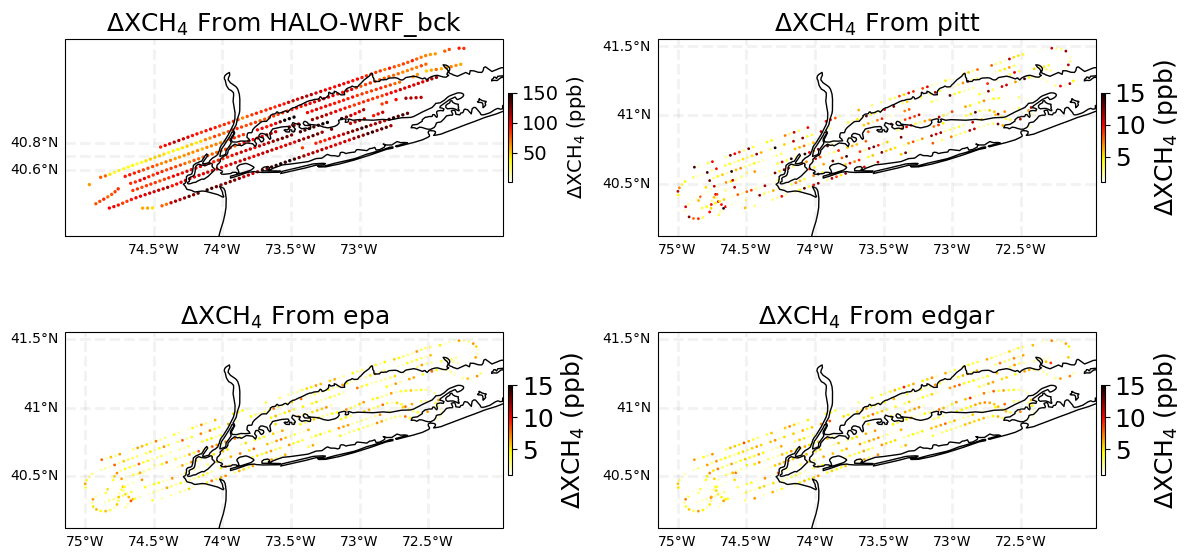

In [96]:
flt = '20230726_F2'
fig,axs = plt.subplots(2,2,figsize=(12,6),subplot_kw={'projection': ccrs.PlateCarree()})
bnds = [1,15]

ax = axs[0,0]
g = ax.scatter(halo[flt]['lon'],halo[flt]['lat'],c=halo[flt]['dxch4']*1e3,cmap=plt.cm.hot_r,transform=ccrs.PlateCarree(),vmin=bnds[0],vmax=150,s=2);
ax.coastlines()
cb = plt.colorbar(g,ax=ax,fraction=0.01,pad=0.01)#,orientation='horizontal')
ax.set_title(f'$\Delta$XCH$_4$ From HALO-WRF_bck',fontsize=18)
#ax.set_xticks(np.linspace(-75,-72,4))
cb.ax.tick_params(labelsize=14)
cb.ax.set_ylabel('$\Delta$XCH$_4$ (ppb)',fontsize=14)
#ax.contour(lon_2km,lat_2km,xco2_b_2km,np.array([-1.0]),cmap=plt.cm.terrain,linewidths=3)
gl = ax.gridlines(xlocs=[-74.5,-74.0,-73.5,-73.0],ylocs=[40.6,40.7,40.8],crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.1, linestyle='--')
gl.top_labels = False
gl.right_labels = False

for ik,ky in enumerate(emis.keys()):
    cmp = plt.cm.hot_r
    ax = axs[(ik+1)//2,(ik+1)%2]
    g = ax.scatter(halo[flt]['lon'],halo[flt]['lat'],c=col[flt][f'dxch4_{ky}'].sum(1)*1e3,cmap=cmp,transform=ccrs.PlateCarree(),vmin=bnds[0],vmax=bnds[1],s=1);
    ax.coastlines()
    cb = plt.colorbar(g,ax=ax,fraction=0.01,pad=0.01)#,orientation='horizontal')
    ax.set_title(f'$\Delta$XCH$_4$ From {ky}',fontsize=18)
    #ax.set_xticks(np.linspace(-75,72,4))
    cb.ax.tick_params(labelsize=18)
    cb.ax.set_ylabel('$\Delta$XCH$_4$ (ppb)',fontsize=18)
    #ax.contour(lon_2km,lat_2km,xco2_b_2km,np.array([-1.0]),cmap=plt.cm.terrain,linewidths=3)
    gl = ax.gridlines(xlocs=[-75.,-74.5,-74.0,-73.5,-73.0,-72.5],ylocs=[40.0,40.5,41.0,41.5],crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.1, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

fig.tight_layout()
fig.savefig('halo_vs_model_enhancements.png',bbox_inches='tight')

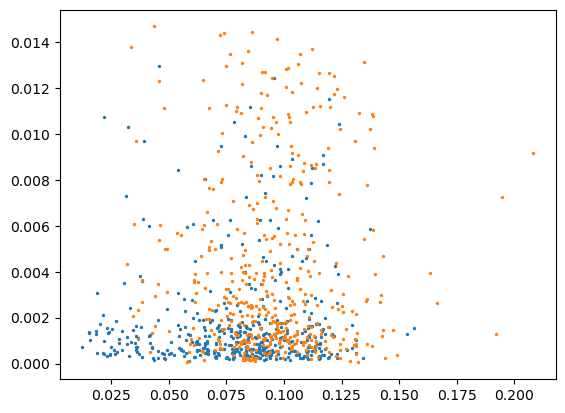

In [97]:
for flt in flts:
    inds = np.where(1-np.isnan(halo[flt]['dxch4']))
    plt.scatter(halo[flt]['dxch4'][inds],col[flt]['dxch4_pitt'].sum(1)[inds],s=2)

# Optimizing Flux Scalar Multiple
Using the formulas in Ye et al (2020) (https://doi.org/10.1029/2019JD030528):

We solve for a single scalar $\lambda$ that scales an inventory up or down. The linearity of the transport means that we can simulate the observations from the inventory once and optimize the mismatch:

$J(\lambda) = (y_o-\lambda y_m)^\mathsf{T} S_o^{-1} (y_o-\lambda y_m) + (\lambda-\lambda_a)^2\sigma_a^{-2}$

with optimizer $\hat{\lambda}$:

$\hat{\lambda} = (y_m^{\mathsf{T}}S_o^{-1}y_m + \sigma_a^{-2})^{-1}(y_m^{\mathsf{T}}S_o^{-1}y_o + \sigma_a^{-2}\lambda_a)$

and uncertainty $\hat{\sigma}^2$:

$\hat{\sigma}^2 = (y_m^{\mathsf{T}}S_o^{-1}y_m + \sigma_a^{-2})^{-1}$


### Read in Emissions

## Methane Optimization

In [11]:
f = File('ch4_emissions_footprint_grid.h5','r')

lat = f['lat'][:]
lon = f['lon'][:]

lat_lb = 40.5
lat_ub = 41.0
lon_lb = -74.5
lon_ub = -73.5
lat_lb_ind = np.where(lat > lat_lb)[0][0]
lat_ub_ind = np.where(lat < lat_ub)[0][-1]
lon_lb_ind = np.where(lon > lon_lb)[0][0]
lon_ub_ind = np.where(lon < lon_ub)[0][-1]

epa_ch4 = f['epa'][:].mean((1,2))#[:,lat_lb_ind:lat_ub_ind,lon_lb_ind:lon_ub_ind].mean((1,2))
edgar_ch4 = f['edgar'][:].mean((1,2))#[:,lat_lb_ind:lat_ub_ind,lon_lb_ind:lon_ub_ind].mean((1,2))
epav2_ch4 = f['epav2'][:].mean((1,2))#[:,lat_lb_ind:lat_ub_ind,lon_lb_ind:lon_ub_ind].mean((1,2))
pitt_ch4 = f['pitt'][:].mean((1,2))#[:,lat_lb_ind:lat_ub_ind,lon_lb_ind:lon_ub_ind].mean((1,2))

### No Noise

Text(0.5, 0, 'Hour')

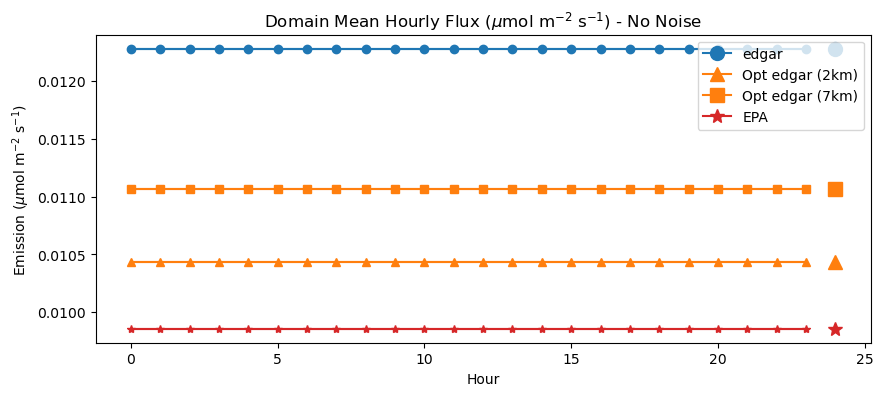

In [12]:
y_m = xch4_e_2km[:].flatten() #EDGAR
y_o = xch4_d_2km[:].flatten() #EPA

lam_apri = 1.
sig_obs = 5.
sig_apri = 0.3

sig_hat_2km = (np.dot(y_m,y_m)*sig_obs**(-2) + sig_apri**(-2))**(-1)
lam_hat_2km = sig_hat_2km*(np.dot(y_m,y_o)*sig_obs**(-2) + lam_apri*sig_apri**(-2))

y_m = xch4_e_7km[:].flatten() #EDGAR
y_o = xch4_d_7km[:].flatten() #EPA


sig_hat_7km = (np.dot(y_m,y_m)*sig_obs**(-2) + sig_apri**(-2))**(-1)
lam_hat_7km = sig_hat_7km*(np.dot(y_m,y_o)*sig_obs**(-2) + lam_apri*sig_apri**(-2))

fig,ax = plt.subplots(1,1,figsize=(10,4))

#ax = axs[0]
ax.plot(lam_apri*edgar_ch4)
ax.plot(lam_apri*edgar_ch4,'tab:blue',marker='o')
g1 = ax.plot([24],[lam_apri*edgar_ch4.mean()],'tab:blue',marker='o',ms=10)

ax.plot(lam_hat_2km*edgar_ch4,'tab:orange')
ax.plot(lam_hat_2km*edgar_ch4,'tab:orange',marker='^')
g2 = ax.plot([24],[lam_hat_2km*edgar_ch4.mean()],'tab:orange',marker='^',ms=10)

ax.plot(lam_hat_7km*edgar_ch4,'tab:orange')
ax.plot(lam_hat_7km*edgar_ch4,'tab:orange',marker='s')
g3 = ax.plot([24],[lam_hat_7km*edgar_ch4.mean()],'tab:orange',marker='s',ms=10)

ax.plot(epa_ch4,'tab:red')
ax.plot(epa_ch4,'tab:red',marker='*')
g4 = ax.plot([24],[epa_ch4.mean()],'tab:red',marker='*',ms=10)

ax.legend([g1[0],g2[0],g3[0],g4[0]],['edgar','Opt edgar (2km)','Opt edgar (7km)','EPA'])
ax.set_title(r'Domain Mean Hourly Flux ($\mu$mol m$^{-2}$ s$^{-1}$) - No Noise')
ax.set_ylabel(r'Emission ($\mu$mol m$^{-2}$ s$^{-1}$)')
ax.set_xlabel(r'Hour')

(0.00816576254229103, 0.016331525084582056)

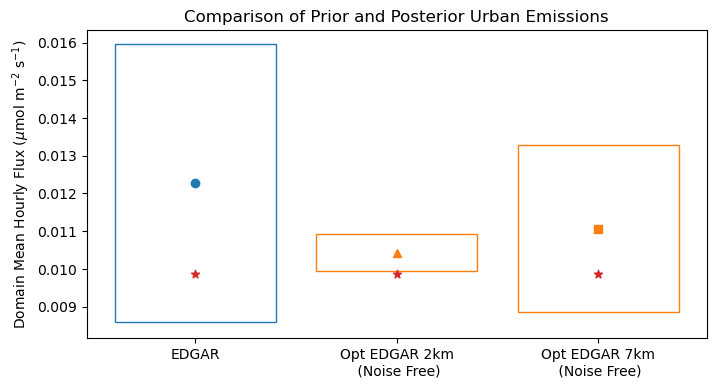

In [15]:

plt.figure(figsize=(8,4))
plt.bar(1,bottom=(lam_apri-sig_apri)*edgar_ch4.mean(),height=2*sig_apri*edgar_ch4.mean(),edgecolor='tab:blue',facecolor='w')
plt.bar(2,bottom=(lam_hat_2km-np.sqrt(sig_hat_2km))*edgar_ch4.mean(),height=2*np.sqrt(sig_hat_2km)*edgar_ch4.mean(),facecolor='w',edgecolor='tab:orange')
plt.bar(3,bottom=(lam_hat_7km-np.sqrt(sig_hat_7km))*edgar_ch4.mean(),height=2*np.sqrt(sig_hat_7km)*edgar_ch4.mean(),facecolor='w',edgecolor='tab:orange')

plt.plot(np.array([1]),edgar_ch4.mean(),'o',color='tab:blue')
plt.plot(np.array([2]),lam_hat_2km*edgar_ch4.mean(),'^',color='tab:orange')
plt.plot(np.array([3]),lam_hat_7km*edgar_ch4.mean(),'s',color='tab:orange')


plt.scatter(np.arange(1,4,1),epa_ch4.mean()*np.ones(3),c='tab:red',marker='*')
plt.xticks([1,2,3],['EDGAR','Opt EDGAR 2km\n (Noise Free)','Opt EDGAR 7km\n (Noise Free)'])
plt.ylabel(r'Domain Mean Hourly Flux ($\mu$mol m$^{-2}$ s$^{-1}$)')
plt.title('Comparison of Prior and Posterior Urban Emissions')
yl = plt.gca().get_ylim()
plt.ylim([yl[0]*0.95,yl[1]])

0.27278949603984515

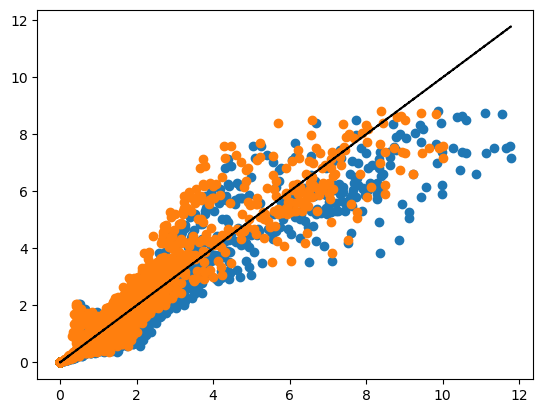

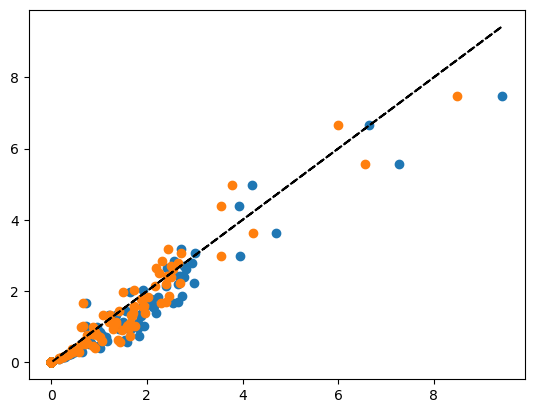

In [21]:
plt.scatter(xch4_e_2km[:].flatten(),xch4_d_2km[:].flatten())
plt.scatter(lam_hat_2km*xch4_e_2km[:].flatten(),xch4_d_2km[:].flatten())
plt.plot(xch4_e_2km[:].flatten(),xch4_e_2km[:].flatten(),'--k')
plt.figure()
plt.scatter(xch4_e_7km[:].flatten(),xch4_d_7km[:].flatten())
plt.scatter(lam_hat_7km*xch4_e_7km[:].flatten(),xch4_d_7km[:].flatten())
plt.plot(xch4_e_7km[:].flatten(),xch4_e_7km[:].flatten(),'--k')
1-(np.sqrt((lam_hat_2km*xch4_e_2km-xch4_d_2km).flatten()**2).mean())/(np.sqrt((xch4_e_2km-xch4_d_2km).flatten()**2).mean())
1-(np.sqrt((lam_hat_2km*xch4_e_7km-xch4_d_7km).flatten()**2).mean())/(np.sqrt((xch4_e_7km-xch4_d_7km).flatten()**2).mean())

### Monte Carlo for Validation

(0.008362415302889364, 0.01637400275246264)

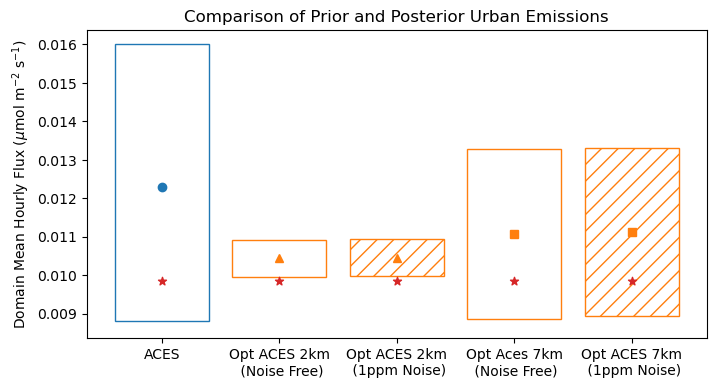

In [44]:
lam_hat_2km_n = np.zeros(1000)
lam_hat_7km_n = np.zeros(1000)
sig_hat_2km_n = np.zeros(1000)
sig_hat_7km_n = np.zeros(1000)
lam_apri = np.zeros(1000)
for i in range(1000):
    
    sig_obs = 5.
    sig_apri = 0.3
    lam_apri[i] = 1.+ sig_apri*np.random.randn()
    
    noise_2km = sig_obs*(np.random.randn(*xch4_e_2km.shape)*lsm_2km).flatten()
    noise_7km = sig_obs*(np.random.randn(*xch4_e_7km.shape)*lsm_7km).flatten()

    y_m = xch4_e_2km[:].flatten() #EDGAR
    y_o = xch4_d_2km[:].flatten() + noise_2km
 
    sig_hat_2km_n[i] = (np.dot(y_m,y_m)*sig_obs**(-2) + sig_apri**(-2))**(-1)
    lam_hat_2km_n[i] = sig_hat_2km_n[i]*(np.dot(y_m,y_o)*sig_obs**(-2) + lam_apri[i]*sig_apri**(-2))

    y_m = xch4_e_7km[:].flatten() #EDGAR
    y_o = xch4_d_7km[:].flatten() + noise_7km

    sig_hat_7km_n[i] = (np.dot(y_m,y_m)*sig_obs**(-2) + sig_apri**(-2))**(-1)
    lam_hat_7km_n[i] = sig_hat_7km_n[i]*(np.dot(y_m,y_o)*sig_obs**(-2) + lam_apri[i]*sig_apri**(-2))

plt.figure(figsize=(8,4))
plt.bar(1,bottom=(lam_apri.mean()-lam_apri.std())*edgar_ch4.mean(),height=2*lam_apri.std()*edgar_ch4.mean(),edgecolor='tab:blue',facecolor='w')
plt.bar(2,bottom=(lam_hat_2km-np.sqrt(sig_hat_2km))*edgar_ch4.mean(),height=2*np.sqrt(sig_hat_2km)*edgar_ch4.mean(),facecolor='w',edgecolor='tab:orange')
plt.bar(3,bottom=(lam_hat_2km_n.mean()-lam_hat_2km_n.std())*edgar_ch4.mean(),height=2*lam_hat_2km_n.std()*edgar_ch4.mean(),hatch='//',facecolor='w',edgecolor='tab:orange')
plt.bar(4,bottom=(lam_hat_7km-np.sqrt(sig_hat_7km))*edgar_ch4.mean(),height=2*np.sqrt(sig_hat_7km)*edgar_ch4.mean(),facecolor='w',edgecolor='tab:orange')
plt.bar(5,bottom=(lam_hat_7km_n.mean()-lam_hat_7km_n.std())*edgar_ch4.mean(),height=2*lam_hat_7km_n.std()*edgar_ch4.mean(),hatch='//',facecolor='w',edgecolor='tab:orange')

plt.plot(np.array([1]),edgar_ch4.mean(),'o',color='tab:blue')
plt.plot(np.array([2]),lam_hat_2km*edgar_ch4.mean(),'^',color='tab:orange')
plt.plot(np.array([3]),lam_hat_2km_n.mean()*edgar_ch4.mean(),'^',color='tab:orange')
plt.plot(np.array([4]),lam_hat_7km*edgar_ch4.mean(),'s',color='tab:orange')
plt.plot(np.array([5]),lam_hat_7km_n.mean()*edgar_ch4.mean(),'s',color='tab:orange')


plt.scatter(np.arange(1,6,1),epa_ch4.mean()*np.ones(5),c='tab:red',marker='*')
plt.xticks([1,2,3,4,5],['ACES','Opt ACES 2km\n (Noise Free)','Opt ACES 2km\n (1ppm Noise)','Opt Aces 7km\n (Noise Free)','Opt ACES 7km\n (1ppm Noise)'])
plt.ylabel(r'Domain Mean Hourly Flux ($\mu$mol m$^{-2}$ s$^{-1}$)')
plt.title('Comparison of Prior and Posterior Urban Emissions')
yl = plt.gca().get_ylim()
plt.ylim([yl[0]*0.95,yl[1]])

In [56]:
(edgar_ch4.mean()/epa_ch4.mean()-edgar_ch4.mean()/epa_ch4.mean()*lam_hat_2km)/(edgar_ch4.mean()/epa_ch4.mean())

0.15025143629307847